In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

# Define dataset paths
dataset_path = "C:/Users/sanke/OneDrive/Desktop/The Stray help/dataset_1"
train_img_dir = os.path.join(dataset_path, "train", "images")
train_lbl_dir = os.path.join(dataset_path, "train", "labels")

valid_img_dir = os.path.join(dataset_path, "valid", "images")
valid_lbl_dir = os.path.join(dataset_path, "valid", "labels")

test_img_dir = os.path.join(dataset_path, "test", "images")
test_lbl_dir = os.path.join(dataset_path, "test", "labels")

IMG_SIZE = 224  # Resize images
BATCH_SIZE = 32

# Class mapping (assuming 0 = not injured, 1 = injured)
CLASS_MAP = {0: "not_injured", 1: "injured"}

def load_data(img_dir, lbl_dir):
    images, labels = [], []

    for img_name in os.listdir(img_dir):
        if img_name.endswith((".jpg", ".png")):
            img_path = os.path.join(img_dir, img_name)
            lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

            # Load image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalize

            # Load label (YOLO format)
            label = 0  # Default to "not injured"
            if os.path.exists(lbl_path):
                with open(lbl_path, "r") as f:
                    label_data = f.readlines()
                
                if len(label_data) > 0:
                    label = int(label_data[0].split()[0])  # Read class ID
                    if label > 1:  # Fix incorrect labels
                        print(f"Warning: Invalid label {label} found in {lbl_path}, setting to 1")
                        label = 1  # Assume it's "injured"

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [2]:
X_train, y_train = load_data(train_img_dir, train_lbl_dir)
X_valid, y_valid = load_data(valid_img_dir, valid_lbl_dir)


In [3]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=2)


In [4]:
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_valid.shape[0]}")

Training samples: 957, Validation samples: 283


In [5]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Binary classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\sanke\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=BATCH_SIZE
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 703ms/step - accuracy: 0.7876 - loss: 0.6510 - val_accuracy: 0.8516 - val_loss: 0.4426
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step - accuracy: 0.8525 - loss: 0.4115 - val_accuracy: 0.8516 - val_loss: 0.4225
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.8697 - loss: 0.3709 - val_accuracy: 0.8516 - val_loss: 0.4358
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.8561 - loss: 0.3952 - val_accuracy: 0.8516 - val_loss: 0.4811
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.8804 - loss: 0.2667 - val_accuracy: 0.8693 - val_loss: 0.4151
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step - accuracy: 0.8807 - loss: 0.2525 - val_accuracy: 0.8339 - val_loss: 0.5003
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.8813 - loss: 0.2412 - val_accuracy: 0.8587 - val_loss: 0.4745
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.9355 - loss: 0.1723 - val_accu

In [7]:
model.save("cnn_model.h5")  # Saves in HDF5 format


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


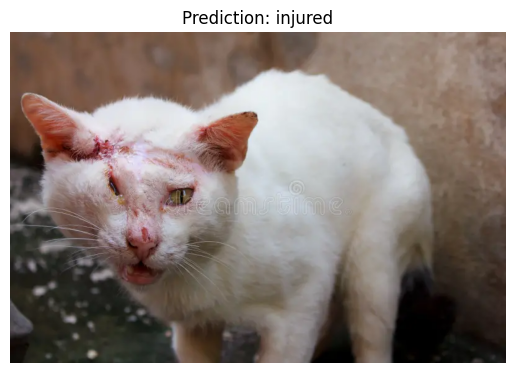

In [8]:
model = keras.models.load_model("cnn_model.h5")
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    class_label = CLASS_MAP[np.argmax(prediction)]

    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {class_label}")
    plt.axis('off')
    plt.show()

# Test with an image
predict_image("C:/Users/sanke/OneDrive/Desktop/The Stray help/ML/cat2.webp")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


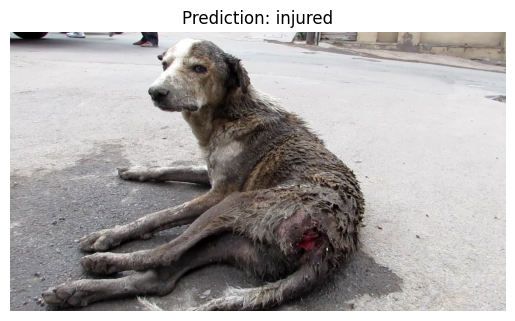

In [9]:
predict_image("C:/Users/sanke/OneDrive/Desktop/The Stray help/ML/maxresdefault.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


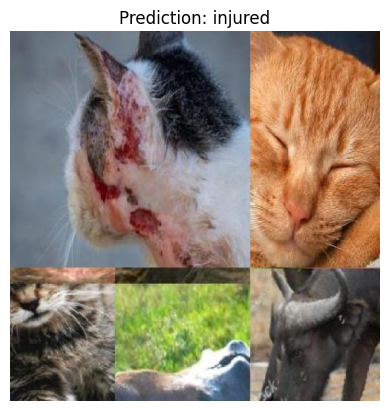

In [10]:
predict_image("test.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


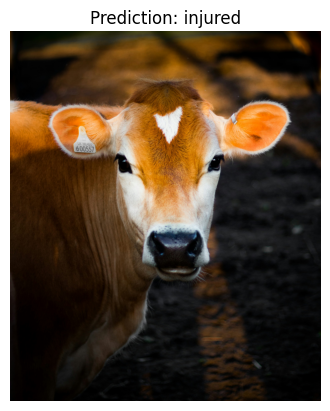

In [11]:
predict_image("C:/Users/sanke/OneDrive/Desktop/The Stray help/ML/cow.jpg")